In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import time

# 1. Construction the matrix X

In [11]:
def construct_X(M, angles, Np=None, tau=0):
    """
    Construct weight matrix for image dimensions MxM,
    angles: Array of sensor angles
    Np: number of sensors
    
    Indice names:
    i_p : sensor index
    i_o : angle/orientation index
    i = i_p + Np * i_o  : response index
    a, b : image coordinates
    j = a + M * b   : flattened image coordinates
    """
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        Np = Np if Np % 2 else Np + 1
#         print(f"Np = {Np}")
    # index boundaries
    D = M**2
    No = len(angles)
    N = No * Np
    
    # coordinate matrix: coordinates of all pixel centers
    # as column vectors
    C = np.mgrid[M-1:-1:-1, :M:1].astype(np.float64).reshape(2, -1)
    center = M / 2
    C += 0.5 - center
        
    # convert angles from degrees to radians
    angles = np.unwrap(np.deg2rad(angles))
    
    # matrix of normal vectors for sensor positions
    n = np.column_stack([np.sin(angles), np.cos(angles)])
    
    # position of sensor 0 to sensor coordinate system
    s0 = Np / 2 - 0.5
    
    # projections of pixel onto sensor
    # first dim: angles, 2. dim: j
    p = np.dot(n, C) + s0

    # floor as left sensor index, fraction as weight for right sensor
    i_ind1, weight2 = np.divmod(p, 1)
    # weight for left sensor, indices for right sensor
    weight1 = 1 - weight2
    i_ind2 = i_ind1 + 1
    # filter all sensor out of range
    mask1 = np.logical_and(i_ind1 >= 0, i_ind1 < Np)
    mask2 = np.logical_and(i_ind2 >= 0, i_ind2 < Np)
    # transform i_ind from i_p to i = i_p + Np * i_o
    for i_o in range(No):
        i_ind1[i_o] += i_o * Np
        i_ind2[i_o] += i_o * Np
    # generate j_indices from mask
    j_ind1 = np.nonzero(mask1.flatten())[0] % D
    j_ind2 = np.nonzero(mask2.flatten())[0] % D
    # concatenate & flatten all indices and weights
    weights = np.concatenate((weight1[mask1].flatten(), weight2[mask2].flatten()))
    i_ind = np.concatenate((i_ind1[mask1].flatten(), i_ind2[mask2].flatten()))
    j_ind = np.concatenate((j_ind1, j_ind2))
    
    # construct sparse matrix convert to csc-matrix for solving
    X = sp.coo_matrix((weights, (i_ind, j_ind)), shape=(N, D), dtype=np.float32)
    if tau == 0:
        return X
    else:
        tau_mat = tau * sp.identity(D)
        return sp.vstack((X, tau_mat), format='csc')

In [12]:
%%timeit
# Test function with example given on sheet
X = construct_X(10, [-33, 1, 42])

548 µs ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
X = construct_X(10, [-33, 1, 42], tau=0.5)

Text(0.5,1,'Weight matrix for $M=10$, angles=[-33,1,42]')

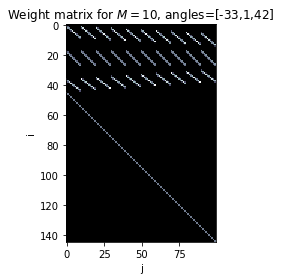

In [20]:
X_dense = X.todense()
plt.imshow(X_dense, cmap='bone')
plt.ylabel('i'); plt.xlabel('j')
plt.title('Weight matrix for $M=10$, angles=[-33,1,42]')

# 2. Recovering the image

In [58]:
def image(alphas, response, M, Np, tau=0, tol=1e-4, verbose=True):
    "Recover image and measure time"
    if verbose:
        print(f"Recovering image with M={M}, Np={Np}, No={len(alphas)}, tolerance={tol}")
    t0 = time.time()
    # construct weight matrix
    X = construct_X(M, alphas, Np)
    t1 = time.time()
    if verbose:
        print(f"Sparsity of X: { 1 - X.nnz / np.product(X.shape)}, Time to construct X: {t1-t0:.2f}s")
    # extend response vector if necesary
    if tau != 0:
        response.resize(100)
    # find least squares solution
    beta = LA.lsqr(X, response, atol=tol, btol=tol)[0]
    t2 = time.time()
    if verbose:
        print(f"Solved for image in {t2-t1:.2f}s with tolerance {tol}, total time {t2-t0:.2f}s")
    return beta.reshape(M,M)